# soynlp로 자연어 처리
* https://github.com/lovit/soynlp

In [1]:
# 출력이 너무 길어지지 않게하기 위해 찍지 않도록 했으나 
# 실제 학습 할 때는 아래 두 줄을 주석처리 하는 것을 권장한다.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


In [3]:
petitions = pd.read_csv('data/petition_sampled.csv')
# 데이터의 크기가 어느정도인지 본다.
petitions.shape

(8029, 8)

In [4]:
petitions.head()

,article_id,start,end,answered,votes,category,title,content
0,58,2017-08-19,2017-11-17,0,21,일자리,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...
1,63,2017-08-20,2017-09-04,0,1,보건복지,살려주세요..,안녕하십니까?\n저는 올해 63세된 홀로 사는 늙은 여자입니다...\n작년 중복날 ...
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...
3,141,2017-08-20,2017-08-27,0,0,기타,한국문화에 창조적요소를 심자,안녕하십니까\n저는 92년 한국을 알게된 종국동포 입니다.\n[저는 한 중소기업에...
4,148,2017-08-20,2017-11-18,0,7,외교/통일/국방,다문화정책 및 할랄 인증 제도,대한민국과 국민을 위해 밤낮 없이 수고하시는 대통령을 비롯한 위정자 분들께\n대한민...


In [5]:
petitions_content = ' '.join(str(petitions['content']))

In [6]:
class Sentences:
    def __init__(self, fname):
        self.fname = fname
        self.length = 0
    def __iter__(self):
        for doc in self.fname:
            doc = doc.strip()
            if not doc:
                continue
            for sent in doc.split(' '):
                yield sent
    def __len__(self):
        if self.length == 0:
            for doc in self.fname:
                doc = doc.strip()
                if not doc:
                    continue
                self.length += len(doc.split(' '))
        return self.length

In [7]:
corpus_fname = petitions_content
sentences = Sentences(corpus_fname)
print('num sentences = %d' % len(sentences))

num sentences = 2633


In [8]:
corpus_fname = petitions['title']
sentences = Sentences(corpus_fname)
print('num sentences = %d' % len(sentences))

num sentences = 37956


In [9]:
%%time
from soynlp.word import WordExtractor

word_extractor = WordExtractor(min_count=100,
                               min_cohesion_forward=0.05, 
                               min_right_branching_entropy=0.0)

word_extractor.train(sentences)
words = word_extractor.extract()

training was done. used memory 0.114 Gb
all cohesion probabilities was computed. # words = 101
all branching entropies was computed # words = 91
all accessor variety was computed # words = 91
CPU times: user 520 ms, sys: 77.9 ms, total: 598 ms
Wall time: 790 ms


In [10]:
import itertools
dict(itertools.islice(words.items(), 5))

{'관': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=-0.0, left_accessor_variety=0, right_accessor_variety=1, leftside_frequency=235, rightside_frequency=106),
 '안': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=0, left_accessor_variety=0, right_accessor_variety=0, leftside_frequency=167, rightside_frequency=126),
 '청': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=0.6794909905550703, left_accessor_variety=0, right_accessor_variety=2, leftside_frequency=972, rightside_frequency=116),
 '학': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=0, left_accessor_variety=0, right_accessor_variety=0, leftside_frequency=125, rightside_frequency=0),
 '한': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=0, left_accessor_variety=0, right_accessor_var

In [11]:
len(words)

198

In [12]:
words['국민']

Scores(cohesion_forward=0.4335347432024169, cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=0, left_accessor_variety=0, right_accessor_variety=0, leftside_frequency=287, rightside_frequency=0)

words는 {word:Score} 형식의 dictionary입니다. Score는 soynlp/word.py에 구현되어있는 namedtuple입니다.

In [13]:
print('type: %s\n' % type(words['가상화폐']))
print(words['가상화폐'])

type: <class 'soynlp.word._word.Scores'>

Scores(cohesion_forward=0.7862404931722864, cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=0, left_accessor_variety=0, right_accessor_variety=0, leftside_frequency=261, rightside_frequency=0)


In [14]:
print('type: %s\n' % type(words['청원']))
print(words['청원'])

type: <class 'soynlp.word._word.Scores'>

Scores(cohesion_forward=0.5051440329218106, cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=-0.0, left_accessor_variety=0, right_accessor_variety=1, leftside_frequency=491, rightside_frequency=0)


In [15]:
def word_score(score):
    import math
    return (score.cohesion_forward * math.exp(score.right_branching_entropy))

print('단어   (빈도수, cohesion, branching entropy)\n')
for word, score in sorted(words.items(), key=lambda x:word_score(x[1]), reverse=True)[:30]:
    print('%s     (%d, %.3f, %.3f)' % (word, 
                                   score.leftside_frequency, 
                                   score.cohesion_forward,
                                   score.right_branching_entropy
                                  ))

단어   (빈도수, cohesion, branching entropy)

청소년     (346, 0.597, 0.692)
폐지     (570, 0.857, -0.000)
합니다     (195, 0.823, -0.000)
출국금지     (321, 0.809, 0.000)
처벌     (251, 0.789, 0.000)
바랍니다     (102, 0.787, 0.000)
가상화폐     (261, 0.786, 0.000)
반대합니다     (166, 0.780, 0.000)
반대     (344, 0.766, -0.000)
만들어     (102, 0.749, 0.000)
부탁드립니다     (101, 0.747, 0.000)
이명박     (537, 0.731, 0.000)
합니     (210, 0.729, -0.000)
가상화     (282, 0.725, -0.000)
합니다.     (106, 0.717, 0.000)
해주세요     (215, 0.715, 0.000)
소년법     (179, 0.712, 0.000)
청원합니다     (238, 0.703, -0.000)
문재인     (139, 0.685, 0.000)
금지     (160, 0.675, 0.000)
청원합니다.     (130, 0.669, 0.000)
주세요     (257, 0.665, 0.000)
출국     (400, 0.660, -0.000)
만들     (119, 0.654, -0.000)
청소년보호법     (112, 0.649, 0.000)
조두순     (186, 0.624, 0.000)
요청     (137, 0.614, 0.000)
국회의원     (100, 0.533, 0.000)
청원     (491, 0.505, -0.000)
부탁드     (108, 0.498, -0.000)


In [16]:
score

Scores(cohesion_forward=0.4982728791224398, cohesion_backward=0, left_branching_entropy=0, right_branching_entropy=-0.0, left_accessor_variety=0, right_accessor_variety=1, leftside_frequency=108, rightside_frequency=0)

In [17]:
from soynlp.tokenizer import RegexTokenizer, LTokenizer, MaxScoreTokenizer

tokenizer = RegexTokenizer()
tokenizer

In [18]:
sample_title = petitions['title'][2]
sample_title

'고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!'

In [19]:
sample_content = petitions['content'][2]
sample_content

"저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등학교 선행학습을 학원다니며 치열하게 하고 있고 주위로부터 고등학교에 가면 국어가 어렵다느니 수학이 어렵다느니 과학이 어렵다느니 이런 말을 많이 듣고 있습니다. 실제로 제가 고등학교 선행학습을 하면 국어, 수학, 영어가 중학교에서 배우던 내용과 다르게 수준이 갑자기 올라가서 ' 아 정말 고등학교를 선행 안 하고 가면 성적이 안나오고 힘들다는 말이 그 말이구나'하는 생각이 듭니다. 고등학교 교육 내용 수준을 낮춰주세요. 그리고 솔직히 말해서 고등학교에서 배우는 내용들은 정말 생활 속에서 잘 쓰이지 않는 것 같아 배울 때 체감도도 떨어지는 것 같습니다. 예를 들어 수학의 미적분 내용은 수학을 전문적으로 다루는 사람이 아니면 실생활에서 사용되지 않는 것 같습니다. 저는 실생활에서 정말 잘 쓰이고 꼭 알아야 될 것들을 배워야 한다고 생각합니다. 고등학교를 위해 제 주변에서도 수 많은 친구들이 선행학습 위해 학원을 다니느라 스트레스도 많이 받습니다. 고등학교 교육 내용을 바꾼다면 사교육도 줄어들지 않을까요"

### RegexTokenizer

In [20]:
tokened_title = tokenizer.tokenize(sample_title)
tokened_title

['고등학교', '교육', '내용', '수준을', '낮춰주시고', '실용적인', '내용을', '담아주세요', '!']

In [21]:
tokened_content = tokenizer.tokenize(sample_content)
tokened_content[:10]

['저는', '광주에', '사는', '중', '3', '학생입니다', '.', '고등학교', '가기', '직전의']

In [22]:
print(len(tokened_title))
print(len(tokened_content))

9
148


In [23]:
import re
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    return text

In [24]:
%time sentences = petitions['content'].apply(preprocessing)

CPU times: user 614 ms, sys: 73.3 ms, total: 687 ms
Wall time: 693 ms


In [25]:
%time sentences = sentences.apply(tokenizer.tokenize)
sentences[:3]

CPU times: user 6.17 s, sys: 48.1 ms, total: 6.21 s
Wall time: 6.23 s


0    [안녕하세요, ?, 존경하고, 지지하는, 문재인, 대통령님, !, 저는, 성남시, ...
1    [안녕하십니까, ?, 저는, 올해, 63, 세된, 홀로, 사는, 늙은, 여자입니다,...
2    [저는, 광주에, 사는, 중, 3, 학생입니다, ., 고등학교, 가기, 직전의, 학...
Name: content, dtype: object

In [26]:
sentences[2][:10]

['저는', '광주에', '사는', '중', '3', '학생입니다', '.', '고등학교', '가기', '직전의']

In [27]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [28]:
# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, min_count=1)

model

2018-05-21 09:22:37,800 : INFO : 'pattern' package not found; tag filters are not available for English
2018-05-21 09:22:37,806 : INFO : collecting all words and their counts
2018-05-21 09:22:37,808 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-21 09:22:38,148 : INFO : collected 206569 word types from a corpus of 998862 raw words and 8029 sentences
2018-05-21 09:22:38,149 : INFO : Loading a fresh vocabulary
2018-05-21 09:22:38,865 : INFO : min_count=1 retains 206569 unique words (100% of original 206569, drops 0)
2018-05-21 09:22:38,866 : INFO : min_count=1 leaves 998862 word corpus (100% of original 998862, drops 0)
2018-05-21 09:22:39,434 : INFO : deleting the raw counts dictionary of 206569 items
2018-05-21 09:22:39,438 : INFO : sample=0.001 downsamples 14 most-common words
2018-05-21 09:22:39,440 : INFO : downsampling leaves estimated 928590 word corpus (93.0% of prior 998862)
2018-05-21 09:22:39,441 : INFO : estimated required memory for 206569

In [29]:
model_name = '1minwords'
model.save(model_name)

2018-05-21 09:22:48,880 : INFO : saving Word2Vec object under 1minwords, separately None
2018-05-21 09:22:48,882 : INFO : storing np array 'syn0' to 1minwords.wv.syn0.npy
2018-05-21 09:22:48,967 : INFO : not storing attribute syn0norm
2018-05-21 09:22:48,969 : INFO : storing np array 'syn1neg' to 1minwords.syn1neg.npy
2018-05-21 09:22:49,057 : INFO : not storing attribute cum_table
2018-05-21 09:22:49,608 : INFO : saved 1minwords


In [30]:
model.wv['청원']

array([ 0.07617449,  0.20977008,  1.2581782 , -0.24207005, -0.26474762,
       -0.29349977,  0.22458446,  0.23255658, -0.1250922 , -0.4431806 ,
       -1.6294241 , -0.42844212,  0.739388  ,  0.8631627 , -1.118183  ,
       -1.4434628 ,  0.9993985 ,  0.682843  , -1.2757899 ,  0.87333024,
       -0.8622338 ,  0.3457278 ,  0.29080755,  1.6249952 ,  1.0378056 ,
        0.02608207, -1.5305091 , -0.64222383, -1.025419  ,  0.73991966,
       -0.809364  ,  0.50733244, -0.66185623,  0.7898801 ,  0.2374757 ,
        0.8367166 ,  0.4629487 , -0.21089742, -0.15016243, -0.93846136,
        0.05709996,  0.06185258,  1.3932308 , -0.74772733,  0.24704261,
       -0.6919753 , -0.48066586, -0.6337776 , -1.6949922 , -1.0502039 ,
       -0.35200277, -0.72083294, -0.5398315 ,  0.7578562 ,  0.3582731 ,
       -0.14439592, -0.99752754, -1.2660218 ,  0.30673796, -0.80115914,
       -0.17487958, -0.19700046,  0.9992945 , -0.28528094, -1.2465109 ,
       -0.27310327, -0.56631815,  2.314672  , -0.6759692 , -0.82

In [31]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('국민 청원 답변 전안법'.split())

2018-05-21 09:22:49,626 : INFO : precomputing L2-norms of word weight vectors


'전안법'

In [32]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('이명박 박근혜 대통령 김정은'.split())

'김정은'

In [33]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('전안법 전기 안전 의류 교통'.split())

'전안법'

In [34]:
# 가장 유사한 단어를 추출
model.wv.most_similar('전안법')

[('너무', 0.9896668791770935),
 ('정말', 0.9886672496795654),
 ('좀', 0.9867804646492004),
 ('투정을', 0.9866671562194824),
 ('좋아', 0.9861547350883484),
 ('화가', 0.9854049682617188),
 ('엄마로서', 0.9848974943161011),
 ('무섭고', 0.9846286773681641),
 ('대접을', 0.9844760298728943),
 ('살기', 0.9844435453414917)]

In [35]:
# 가장 유사한 단어를 추출
model.wv.most_similar('대통령')

[('청와대', 0.9971941709518433),
 ('대통령의', 0.9962314367294312),
 ('박근혜', 0.9955627918243408),
 ('사건은', 0.9953163266181946),
 ('강화', 0.9947912693023682),
 ('게시판에', 0.9941489100456238),
 ('대통령에게', 0.993902325630188),
 ('전자', 0.9938817024230957),
 ('박상기', 0.9937328696250916),
 ('인상', 0.9937118291854858)]

In [36]:
# 가장 유사한 단어를 추출
model.wv.most_similar('가상화폐')

[('폐쇄', 0.9989378452301025),
 ('여성은', 0.9986142516136169),
 ('규제', 0.9986109137535095),
 ('적극', 0.9985002875328064),
 ('군대', 0.9982213973999023),
 ('평소', 0.9980505108833313),
 ('법의', 0.9977590441703796),
 ('국민', 0.9976036548614502),
 ('자세히', 0.9974144101142883),
 ('보면', 0.9973999261856079)]

In [37]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('이명박 박근혜 대통령 김정은 문재인'.split())

'문재인'

In [38]:
model.wv.most_similar(positive=['학교', '공교육'], negative=['학원'])

[('면적을', 0.9876424670219421),
 ('처음에', 0.9870693683624268),
 ('정현백', 0.9854709506034851),
 ('국회의원들과', 0.9853626489639282),
 ('비롯해서', 0.9850428104400635),
 ('받고있습니다', 0.9849839210510254),
 ('거짓말하고', 0.984810471534729),
 ('아쉬운', 0.9847652316093445),
 ('어렵습니다', 0.984544575214386),
 ('월급도', 0.9843773245811462)]

In [39]:
model.wv.most_similar(positive=['블록체인', '가상화폐'], negative=['주식'])

[('과목을', 0.9949473142623901),
 ('있었기에', 0.9948616623878479),
 ('결정을', 0.9936246871948242),
 ('답변을', 0.9935872554779053),
 ('그것이', 0.9932889342308044),
 ('매우', 0.9932506680488586),
 ('바로', 0.9932137131690979),
 ('뜻으로', 0.9932019710540771),
 ('어렵다', 0.993175745010376),
 ('부합하지', 0.9931688904762268)]

### 단어 유사도

In [40]:
model.wv.similarity('블록체인', '가상화폐')

0.994214756718857

In [41]:
model.wv.similarity('블록체인', '현금')

0.9486054370019454

In [42]:
model.wv.similarity('블록체인', '주식')

0.9828916039899454

In [43]:
model.wv.similarity('블록체인', '종이')

0.9321218041262749

### 단어 유사도 시각화

In [44]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '1minwords'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

2018-05-21 09:22:50,490 : INFO : loading Doc2Vec object from 1minwords
2018-05-21 09:22:51,164 : INFO : loading wv recursively from 1minwords.wv.* with mmap=None
2018-05-21 09:22:51,165 : INFO : loading syn0 from 1minwords.wv.syn0.npy with mmap=None
2018-05-21 09:22:51,203 : INFO : setting ignored attribute syn0norm to None
2018-05-21 09:22:51,205 : INFO : loading syn1neg from 1minwords.syn1neg.npy with mmap=None
2018-05-21 09:22:51,287 : INFO : setting ignored attribute cum_table to None
2018-05-21 09:22:51,288 : INFO : loaded 1minwords


206569
[-0.1231749   0.56951934  1.7211077   0.12570687 -0.60382795  0.5727404
  0.21152154  0.43570215 -0.47482872 -0.01017217]


In [45]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [46]:
# 전처리가 좀 더 필요
df.head(10)

,x,y
안녕하세요,0.874700,-4.066907
?,2.421838,-5.117727
존경하고,-1.103315,4.784029
지지하는,-0.515348,1.048055
문재인,0.391786,-7.100470
대통령님,-0.041421,-7.158010
!,0.465339,-7.431653
저는,0.055508,-7.843246
성남시,-1.766745,4.217094
분당구,-2.019911,6.612713


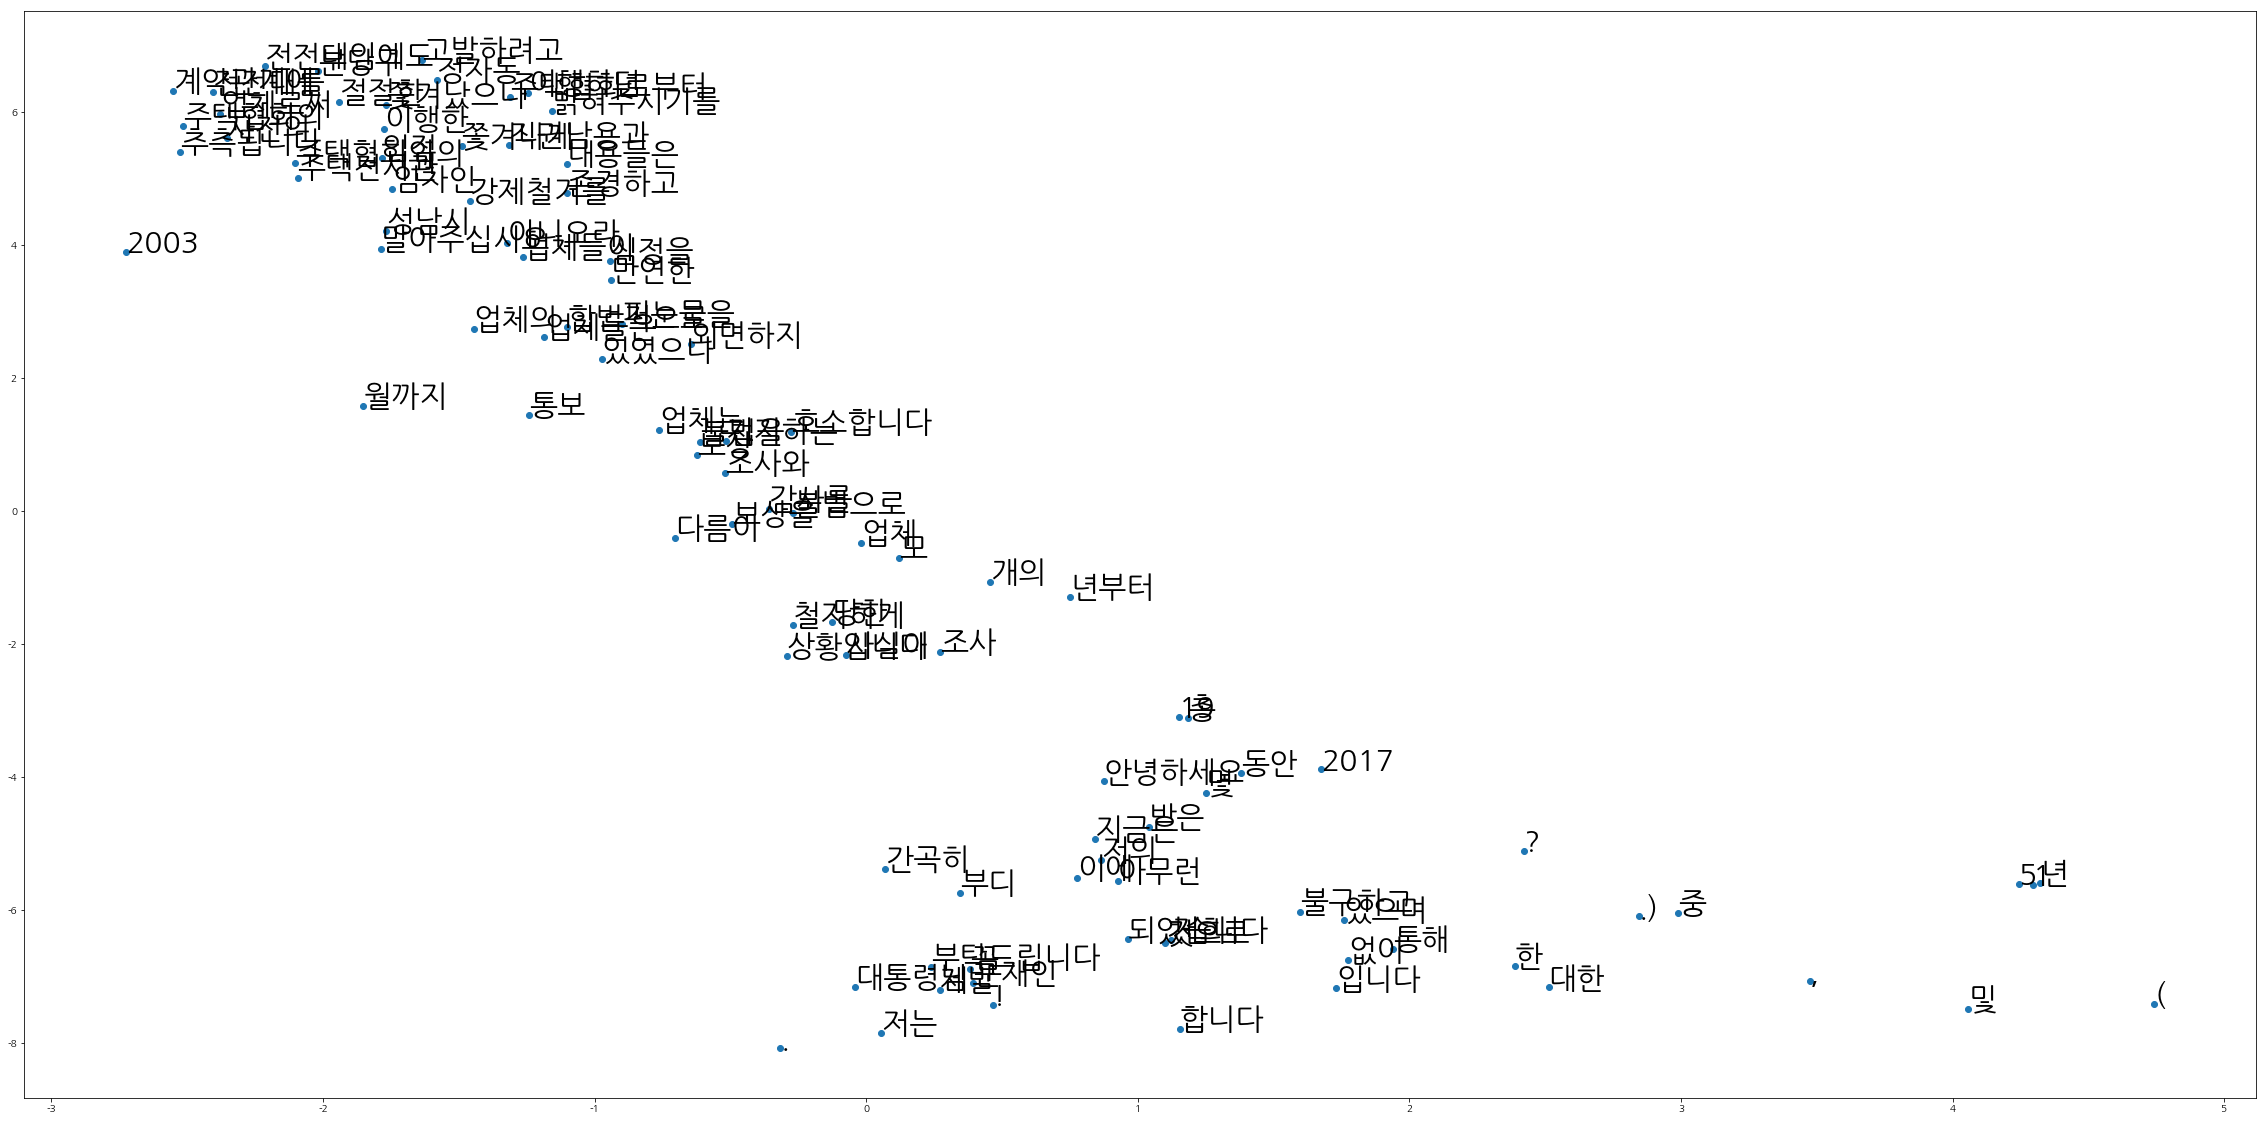

In [47]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

조사와 불용어가 섞여 있어서 시각화가 제대로 되지 않는다. 데이터 정제가 필요하다.

In [ ]:
from soynlp.noun import LRNounExtractor

corpus = DoublespaceLineCorpus(corpus_fname, iter_sent=False, num_doc=3)
corpus = DoublespaceLineCorpus(corpus_fname, iter_sent=True)
noun_extractor = LRNounExtractor()
nouns = noun_extractor.train_extract(corpus)